# Section 6b: Optimizing an ARC

In the previous example, we introduced a simple one-layer anti-reflection coating
(ARC); ARCs are a standard feature of all high-efficiency solar cells. But how do you
find out
the right thickness for the anti-reflection coating layer(s) (or the right dimensions
 for a light-trapping grating, or some other structure in your cell)? This is where
 optimization comes in. Here, we will look at a very simple 'brute-force' optimization for a single or double-layer ARC.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from solcore import material, si
from solcore.solar_cell import Layer, SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
from solcore.absorption_calculator import search_db, download_db
from solcore.absorption_calculator import calculate_rat
from solcore.state import State

from rayflare.transfer_matrix_method import tmm_structure
from rayflare.options import default_options
import seaborn as sns

name 'dd' is not defined


/Users/z3533914/.pyenv/versions/3.11.5/lib/python3.11/site-packages/solcore/registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


## Setting up
We set some options, as in previous examples, setting the wavelengths and defining
the incident spectrum. We are going to do a partially coherent calculation, treating
the ARC as a coherent layer and the thick Si layer as incoherent (no thin-film
interference).

In [2]:
opts = State()

wavelengths = np.linspace(300, 1200, 800)*1e-9

AM15g = LightSource(source_type="standard", version="AM1.5g", output_units="photon_flux_per_m")
spectrum = AM15g.spectrum(wavelengths)[1]
normalised_spectrum = spectrum/np.max(spectrum)

opts.wavelength = wavelengths
opts.coherency_list = ['c', 'i']
opts.optics_method = 'TMM'
opts.position = 100e-6
opts.no_back_reflection = False

Si = material("Si")()
SiN = material("Si3N4")()
Ag = material("Ag")()
Air = material("Air")()

## Single-layer ARC

Here, we will calculate the behaviour of a single-layer SiN anti-reflection coating
on Si while changing the ARC thickness between 0 and 200 nm. We will consider two
values to optimize: the mean reflectance `mean_R`, and the reflectance weighted by
the photon flux in an AM1.5G spectrum (`weighted_R`). The reason for considering the
second value is that it is more useful to suppress reflection at wavelengths where
there are more photons which could be absorbed by the cell (up to the cell's bandgap).

We will loop through the different ARC thicknesses in `d_range`, build the structure for each case, and then calculate the reflectance. We then save the mean reflected and weighted mean reflectance in the corresponding arrays. We also plot the reflectance for each 15th loop (this is just so the plot does not get too crowded).

Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Ca

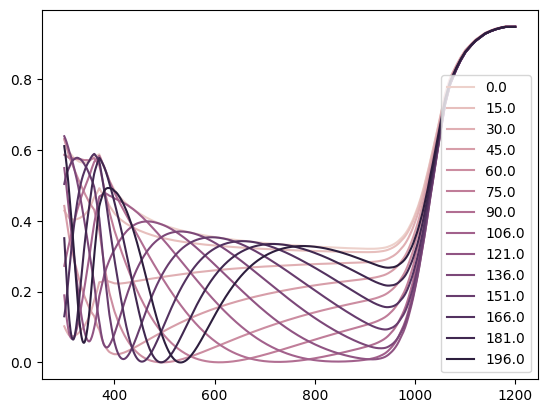

In [3]:
#| output: false
d_range = np.linspace(0, 200, 200)

mean_R = np.empty_like(d_range)
weighted_R = np.empty_like(d_range)

cols = sns.cubehelix_palette(np.ceil(len(d_range)/15))

plt.figure()
jcol = 0

for i1, d in enumerate(d_range):

    struct = SolarCell([Layer(si(d, 'nm'), SiN), Layer(si('120um'), Si)], substrate=Ag)
    solar_cell_solver(struct, task='optics', user_options=opts)

    if i1 % 15 == 0:
        plt.plot(wavelengths*1e9, struct.reflected, label=str(np.round(d, 0)), color=cols[jcol])
        jcol += 1

    mean_R[i1] = np.mean(struct.reflected)
    weighted_R[i1] = np.mean(struct.reflected*normalised_spectrum)

plt.legend()
plt.show()

We now find at which index `mean_R` and `weighted_R` are minimised using `np.argmin`, and use this to print the ARC thickness at which this occurs (rounded to 1 decimal place).

In [4]:
print('Minimum mean reflection occurs at d = ' + str(np.round(d_range[np.argmin(mean_R)], 1)) + ' nm')
print('Minimum weighted reflection occurs at d = ' + str(np.round(d_range[np.argmin(weighted_R)], 1)) + ' nm')

Minimum mean reflection occurs at d = 67.3 nm
Minimum weighted reflection occurs at d = 74.4 nm


We see that the values of $d$ for the two different ways of optimizing are very
similar, but not exactly the same, as we would expect. The minimum in both cases
occurs around 70 nm. We can also plot the variation of the mean and weighted $R$ with
ARC thickness $d$:

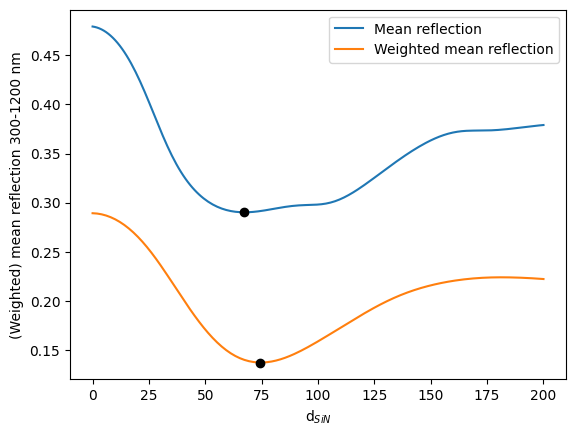

In [5]:
plt.figure()
plt.plot(d_range, mean_R, label='Mean reflection')
plt.plot(d_range[np.argmin(mean_R)], np.min(mean_R), 'ok')
plt.plot(d_range, weighted_R, label='Weighted mean reflection')
plt.plot(d_range[np.argmin(weighted_R)], np.min(weighted_R), 'ok')
plt.xlabel('d$_{SiN}$')
plt.ylabel('(Weighted) mean reflection 300-1200 nm')
plt.legend()
plt.show()

Now, to see what the reflectance looks like for the optimized structure, we make new
`tmm_structure`s with the optimal values and calculate and plot the reflectance:

Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...
Treating layer(s) 1 incoherently
Calculating RAT...
Calculating absorption profile...


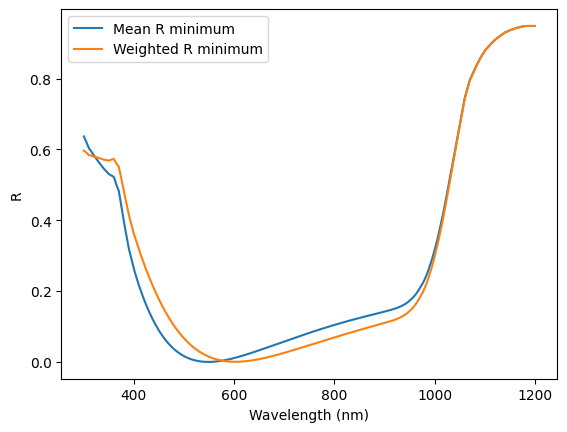

In [6]:
struct_1 = SolarCell([Layer(si(d_range[np.argmin(mean_R)], 'nm'), SiN), Layer(si('120um'), Si)], substrate=Ag)
solar_cell_solver(struct_1, task='optics', user_options=opts)
R_1 = struct_1.reflected

struct_2 = SolarCell([Layer(si(d_range[np.argmin(weighted_R)], 'nm'), SiN), Layer(si('120um'), Si)], substrate=Ag)
solar_cell_solver(struct_2, task='optics', user_options=opts)
R_2 = struct_2.reflected

plt.figure()
plt.plot(wavelengths*1e9, R_1, label='Mean R minimum')
plt.plot(wavelengths*1e9, R_2, label='Weighted R minimum')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("R")
plt.show()

We see that the two reflectance curves are very similar, as expected because the
layer thicknesses are very similar.

## Double-layer ARC

We will now consider a similar situation, but for a double-layer MgF$_2$/Ta$_2$O$_5$
ARC on GaAs.

Solcore can directly interface with the database from www.refractiveindex.info,
which contains around 3000 sets of  data for a large number of different materials.
Before the first use, it is necessary to download the database. This only needs to
be done once, so you can comment this line out after it’s done:

In [7]:
download_db(confirm=True) # only needs to be done once

Database file found at /Users/z3533914/.solcore/nk/nk.db
Making request to https://refractiveindex.info/download/database/rii-database-2021-07-18.zip
Downloaded and extracting...


We search for materials in the refractiveindex.info database, and use
only the part of the solar spectrum relevant for absorption in GaAs (in this case,
there is no benefit to reducing absorption above the GaAs bandgap around 900 nm). We
will only consider the weighted mean $R$ in this case. Since all the layers in the
structure are relatively thin compared to the wavelengths of light, we do a
coherent calculation.

In [ ]:
#| output: false

pageid_MgF2 = search_db(os.path.join("MgF2", "Rodriguez-de Marcos"))[0][0]
pageid_Ta2O5 = search_db(os.path.join("Ta2O5", "Rodriguez-de Marcos"))[0][0]

GaAs = material("GaAs")()
MgF2 = material(str(pageid_MgF2), nk_db=True)()
Ta2O5 = material(str(pageid_Ta2O5), nk_db=True)()

MgF2_thickness = np.linspace(50, 100, 20)
Ta2O5_thickness = np.linspace(30, 80, 20)

weighted_R_matrix = np.zeros((len(MgF2_thickness), len(Ta2O5_thickness)))

wavelengths_GaAs = wavelengths[wavelengths < 900e-9]
normalised_spectrum_GaAs = normalised_spectrum[wavelengths < 900e-9]

opts.coherency_list = None
opts.wavelength = wavelengths_GaAs
opts.position = 20e-6

We now have two thicknesses to loop through; otherwise, the procedure is similar to the single-layer ARC example.

In [ ]:
#| output: false

for i1, d_MgF2 in enumerate(MgF2_thickness):
    for j1, d_Ta2O5 in enumerate(Ta2O5_thickness):
        struct = SolarCell([Layer(si(d_MgF2, 'nm'), MgF2), Layer(si(d_Ta2O5, 'nm'), Ta2O5),
                                Layer(si('20um'), GaAs)],
                               substrate=Ag)
        solar_cell_solver(struct, 'optics', opts)
        R = struct.reflected

        weighted_R_matrix[i1, j1] = np.mean(R * normalised_spectrum_GaAs)

# find the row and column indices of the minimum weighted R value
ri, ci = np.unravel_index(weighted_R_matrix.argmin(), weighted_R_matrix.shape)

We plot the total absorption ($1-R$) in the structure with the optimized ARC, and print the thicknesses of MgF$_2$ and Ta$_2$O$_5$ at which this occurs:

In [ ]:
plt.figure()
plt.imshow(1-weighted_R_matrix, extent=[min(Ta2O5_thickness), max(Ta2O5_thickness),
                                        min(MgF2_thickness), max(MgF2_thickness)],
           origin='lower', aspect='equal')
plt.plot(Ta2O5_thickness[ci], MgF2_thickness[ri], 'xk')
plt.colorbar()
plt.xlabel("Ta$_2$O$_5$ thickness (nm)")
plt.ylabel("MgF$_2$ thickness (nm)")
plt.show()

print("Minimum reflection occurs at MgF2 / Ta2O5 thicknesses of %.1f / %.1f nm "
     % (MgF2_thickness[ri], Ta2O5_thickness[ci]))

For these two examples, where we are only trying to optimize one and two parameters
respectively across a relatively small range, using a method (TMM) which executes
quickly, brute force searching is possible. However, as we introduce more parameters,
 a wider parameter space, and slower simulation methods, it may no longer be
 computationally tractable; in that case, using for example differential evolution or
  other types of numerical optimization may be more appropriate (see [this example](
  ../../solar-cell-simulation/notebooks/7b-optimization.ipynb)).

## Questions

- Apart from varying the thickness of the layers, what else could we change?
- How do we know where to start when designing an ARC (layer thickness/material)?